In [4]:
import pandas as pd
import requests as req
from bs4 import BeautifulSoup as bs



   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.7 MB 1.2 MB/s eta 0:00:08
   --- ------------------------------------ 0.8/9.7 MB 1.1 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/9.7 MB 1.2 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.7 MB 1.2 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.7 MB 1.3 MB/s eta 0:00:07
   -------- ------------------------------- 2.1/9.7 MB 1.3 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/9.7 MB 1.3 MB/s eta 0:00:06
   ---------- ----------------------------- 2.6/9.7 MB 1.4 MB/s eta 0:00:06
   ----------- ---------------------------- 2.9/9.7 MB 1.3 MB/s eta 0:00:06
   ------------ --------------------------- 3.1/9.7 MB 1.3 MB/s eta 0:00:05
   --------------- --------------

,subcategory,page,url
0,DIY RC Parts,1,https://www.banggood.com/Wholesale-RC-Parts-ca...
1,DIY RC Parts,2,https://www.banggood.com/Wholesale-RC-Parts-ca...
2,RC Vehicles,1,https://www.banggood.com/Wholesale-RC-Vehicles...
3,RC Vehicles,2,https://www.banggood.com/Wholesale-RC-Vehicles...
4,Science and Discovery Toys,1,https://www.banggood.com/Wholesale-Science-and...
5,Science and Discovery Toys,2,https://www.banggood.com/Wholesale-Science-and...
6,RC Drones,1,https://www.banggood.com/Wholesale-RC-Drones-c...
7,RC Drones,2,https://www.banggood.com/Wholesale-RC-Drones-c...
8,Cycling,1,https://www.banggood.com/Wholesale-Cycling-ca-...
9,Cycling,2,https://www.banggood.com/Wholesale-Cycling-ca-...


In [6]:
# !apt-get update
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# !pip install selenium

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import re

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

# Initialize the driver
driver = webdriver.Chrome(options=chrome_options)
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

In [7]:
def parse_products_selenium(driver, main_category, sub_category):
    """
    Parse product data from the current page using Selenium
    """
    products = []

    try:
        # Wait for products to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".goodlist li"))
        )

        # Find all product elements
        product_elements = driver.find_elements(By.CSS_SELECTOR, ".goodlist li")

        for product in product_elements:
            try:
                product_data = {}
                product_data['main_category'] = main_category  # Add main category
                product_data['subcategory'] = sub_category

                # Extract product ID
                product_id = product.get_attribute('data-product-id')
                product_data['product_id'] = product_id

                # Extract title
                try:
                    title_elem = product.find_element(By.CSS_SELECTOR, ".title")
                    product_data['title'] = title_elem.text.strip()
                    product_data['product_url'] = title_elem.get_attribute('href')
                except:
                    product_data['title'] = None
                    product_data['product_url'] = None

                # Extract current price
                try:
                    price_elem = product.find_element(By.CSS_SELECTOR, ".price")
                    product_data['price'] = price_elem.text.strip()
                except:
                    product_data['price'] = None

                # Extract old price (if available)
                try:
                    old_price_elem = product.find_element(By.CSS_SELECTOR, ".price-old")
                    product_data['old_price'] = old_price_elem.text.strip()
                except:
                    product_data['old_price'] = None

                # Extract reviews count
                try:
                    review_elem = product.find_element(By.CSS_SELECTOR, ".review")
                    review_text = review_elem.text.strip()
                    product_data['reviews_count'] = review_text.split()[0] if review_text else '0'
                except:
                    product_data['reviews_count'] = '0'

                # Extract rating
                try:
                    rating_elem = product.find_element(By.CSS_SELECTOR, ".review-text")
                    product_data['rating'] = rating_elem.text.strip()
                except:
                    product_data['rating'] = None

                # Extract image URL
                try:
                    img_elem = product.find_element(By.CSS_SELECTOR, ".lazy")
                    product_data['image_url'] = img_elem.get_attribute('src')
                except:
                    product_data['image_url'] = None

                # Extract shipping info
                try:
                    shipping_elem = product.find_element(By.CSS_SELECTOR, ".free-text")
                    product_data['shipping_info'] = shipping_elem.text.strip()
                except:
                    product_data['shipping_info'] = None

                products.append(product_data)

            except Exception as e:
                print(f"    Error parsing individual product: {e}")
                continue

    except Exception as e:
        print(f"    Error finding products on page: {e}")

    return products

In [9]:
import requests, time
from bs4 import BeautifulSoup
import pandas as pd

headers = {"User-Agent": "Mozilla/5.0"}

def make_page_url(url, page):
    # add ?page=N or &page=N
    return url + ("&" if "?" in url else "?") + f"page={page}"
def parse_products(html, sub_cat):
    soup = BeautifulSoup(html, "lxml")
    rows = []

    # every product is a <li> inside <ul class="goodlist">
    for li in soup.select("ul.goodlist > li"):
        title_el   = li.select_one("a.title")
        price_el   = li.select_one("span.price-box span.price")
        reviews_el = li.select_one("a.review")
        rating_el  = li.select_one("div.reivew-box span.review-text")
        link_el    = li.select_one("a.title")

        rows.append({
            "subcategory": sub_cat,
            "name": title_el.get_text(strip=True) if title_el else None,
            "price_raw": price_el.get_text(strip=True) if price_el else None,
            "reviews_raw": reviews_el.get_text(strip=True) if reviews_el else None,
            "rating_raw": rating_el.get_text(strip=True) if rating_el else None,
            "url": link_el["href"] if link_el and link_el.has_attr("href") else None,
        })

    return rows


In [10]:

# Initialize the driver
driver = webdriver.Chrome(options=chrome_options)
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

# Your categories structure
categories = {
    "Toys, Hobbies and Robots": {
        "DIY RC Parts": "https://www.banggood.com/Wholesale-RC-Parts-ca-7013.html",
        "RC Vehicles": "https://www.banggood.com/Wholesale-RC-Vehicles-ca-7007.html",
        "Science and Discovery Toys": "https://www.banggood.com/Wholesale-Science-and-Discovery-Toys-ca-18977.html?bid=21070104&from=nav",
        "RC Drones": "https://www.banggood.com/Wholesale-RC-Drones-ca-7002.html?bid=21070101&from=nav"
    },
    "Sports and Outdoor": {
        "Cycling": "https://www.banggood.com/Wholesale-Cycling-ca-6002.html",
        "Camping": "https://www.banggood.com/Wholesale-Camping-ca-6030.html",
        "Sports & Fitness": "https://www.banggood.com/Wholesale-Fitness-Wellness-ca-6016.html",
        "Water Sports": "https://www.banggood.com/Wholesale-Water-Sports-ca-6059.html",
        "Fishing & Hunting": "https://www.banggood.com/Wholesale-Fishing-and-Hunting-ca-6023.html"
    },

    "Men & Women's Clothing": {
        "Men's Clothing": "https://www.banggood.com/Wholesale-Mens-Clothing-ca-15001.html",
        "Women's Clothing": "https://www.banggood.com/Wholesale-Womens-Clothing-ca-16001.html",
        "Beauty & Styling": "https://www.banggood.com/Wholesale-Beauty-and-Styling-ca-18948.html",
        "Jewelry & Watches": "https://www.banggood.com/Wholesale-Jewelry,Watches-and-Accessories-ca-8001.html",
        "Men's Accessories": "https://www.banggood.com/Wholesale-Mens-Accessories-ca-10007.html"
    },
     "Computers,Videos & Games" : {
         "Drives and Storage": "https://www.banggood.com/Wholesale-Drives-and-Storage-ca-5053.html",
         "Computer Components" : "https://www.banggood.com/Wholesale-Computer-Components-ca-5035.html",
         "Computer Peripherals" : "https://www.banggood.com/Wholesale-Computer-Peripherals-ca-5005.html",
         "Tv & Projectors": "https://www.banggood.com/Wholesale-Projectors-and-Accessories-ca-5083.html",
         "Video Games Accessories":"https://www.banggood.com/Wholesale-Video-Games-Accessories-ca-2432.html"
     }
}

# Main scraping loop with nested categories
all_rows = []
all_urls = []

# Loop through main categories and their subcategories
for main_cat, subcategories_dict in categories.items():
    print(f"\n{'='*50}")
    print(f"Scraping MAIN CATEGORY: {main_cat}")
    print(f"{'='*50}")

    for sub_cat, base_url in subcategories_dict.items():
        print(f"\nScraping sub-category: {sub_cat}")

        for page in range(1, 5):  # 1-2 pages for testing
            page_url = make_page_url(base_url, page)

            # Save this URL in our tracking list
            all_urls.append({
                "main_category": main_cat,
                "subcategory": sub_cat,
                "page": page,
                "url": page_url
            })

            try:
                print(f"  Page {page} → {page_url}")

                # Navigate to the page
                driver.get(page_url)

                # Wait a bit for page to load
                time.sleep(3)

                # Parse products - now passing both main_category and sub_category
                page_rows = parse_products_selenium(driver, main_cat, sub_cat)

                if not page_rows:
                    print("    No products found, stopping this sub-category.")
                    break

                all_rows.extend(page_rows)
                print(f"    Found {len(page_rows)} products")

                time.sleep(2)  # Be polite

            except Exception as e:
                print(f"    Error on page {page}: {e}")
                break

# Close the driver when done
driver.quit()

# Create DataFrames
if all_rows:
    df = pd.DataFrame(all_rows)
    df_urls = pd.DataFrame(all_urls)

    print(f"\nScraping completed!")
    print(f"Total products scraped: {len(df)}")
    print(f"Total URLs attempted: {len(df_urls)}")

    # Display category breakdown
    print(f"\nCategory Breakdown:")
    category_counts = df.groupby(['main_category', 'subcategory']).size().reset_index(name='count')
    for _, row in category_counts.iterrows():
        print(f"  {row['main_category']} -> {row['subcategory']}: {row['count']} products")

    # Display first few rows
    print("\nFirst few products:")
    print(df.head())

    # Save to CSV
    df.to_csv('banggood_products_with_categories.csv', index=False)
    df_urls.to_csv('banggood_urls_with_categories.csv', index=False)
    print("\nData saved to banggood_products_with_categories.csv and banggood_urls_with_categories.csv")
else:
    print("No data was scraped.")


Scraping MAIN CATEGORY: Toys, Hobbies and Robots

Scraping sub-category: DIY RC Parts
  Page 1 → https://www.banggood.com/Wholesale-RC-Parts-ca-7013.html?page=1
    Found 30 products
  Page 2 → https://www.banggood.com/Wholesale-RC-Parts-ca-7013.html?page=2


KeyboardInterrupt: 

Part 2: Data Cleaning & Transformation
1. Load scraped data into pandas DataFrames.
2. Clean price, rating, review counts, and handle missing values.
3. Create at least two additional derived features.


In [11]:
df = pd.read_csv('raw_data.csv')




In [12]:
import pandas as pd
import numpy as np
import re

# 1. Load scraped data into pandas DataFrames
print("1. LOADING DATA INTO PANDAS DATAFRAMES")
print("="*50)

# Load the main products data

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 3 rows:")
print(df.head(3))

# 2. Clean price, rating, review counts, and handle missing values
print("\n\n2. DATA CLEANING")
print("="*50)

def clean_banggood_data(df):
    """
    Comprehensive cleaning function for Banggood data
    """
    df_clean = df.copy()

    # Clean Price Data
    print("Cleaning price data...")
    def extract_price(price_str):
        if pd.isna(price_str) or price_str in ['N/A', 'None', '']:
            return np.nan
        try:
            # Remove "US$" and convert to float
            price_clean = str(price_str).replace('US$', '').strip()
            return float(price_clean)
        except:
            return np.nan

    df_clean['price_clean'] = df_clean['price'].apply(extract_price)
    df_clean['old_price_clean'] = df_clean['old_price'].apply(extract_price)

    # Clean Rating Data
    print("Cleaning rating data...")
    df_clean['rating_clean'] = pd.to_numeric(df_clean['rating'], errors='coerce')

    # Clean Review Counts
    print("Cleaning review counts...")
    def clean_reviews(review_str):
        if pd.isna(review_str) or review_str in ['N/A', 'None', '']:
            return 0
        try:
            # Extract numbers only
            review_num = re.findall(r'\d+', str(review_str))
            return int(review_num[0]) if review_num else 0
        except:
            return 0

    df_clean['reviews_clean'] = df_clean['reviews_count'].apply(clean_reviews)

    # Handle Missing Values
    print("Handling missing values...")

    # Display missing values before cleaning
    print("\nMissing values before cleaning:")
    missing_before = df_clean[['price_clean', 'old_price_clean', 'rating_clean', 'reviews_clean']].isnull().sum()
    print(missing_before)

    # Fill missing values
    df_clean['price_clean'].fillna(df_clean['price_clean'].median(), inplace=True)
    df_clean['old_price_clean'].fillna(0, inplace=True)  # 0 means no old price
    df_clean['rating_clean'].fillna(0, inplace=True)  # 0 means no rating
    df_clean['reviews_clean'].fillna(0, inplace=True)  # 0 means no reviews

    # Fill text missing values
    text_columns = ['title', 'product_url', 'shipping_info', 'image_url']
    for col in text_columns:
        if col in df_clean.columns:
            df_clean[col].fillna('Unknown', inplace=True)

    # Fill product_id
    if 'product_id' in df_clean.columns:
        df_clean['product_id'].fillna('Unknown', inplace=True)

    print("\nMissing values after cleaning:")
    missing_after = df_clean[['price_clean', 'old_price_clean', 'rating_clean', 'reviews_clean']].isnull().sum()
    print(missing_after)

    return df_clean

# Apply cleaning
df_cleaned = clean_banggood_data(df)
print(f"\nData shape after cleaning: {df_cleaned.shape}")

# 3. Create two derived features: Price Category and Discount
print("\n\n3. CREATING DERIVED FEATURES")
print("="*50)

def create_derived_features(df):
    """
    Create two derived features: Price Category and Discount Analysis
    """
    df_enhanced = df.copy()

    # DERIVED FEATURE 1: PRICE CATEGORY
    print("Creating Feature 1: Price Category...")

    def categorize_price(price):
        """
        Categorize products into price ranges
        """
        if price < 10:
            return 'Budget (<$10)'
        elif price < 25:
            return 'Economy ($10-25)'
        elif price < 50:
            return 'Standard ($25-50)'
        elif price < 100:
            return 'Premium ($50-100)'
        else:
            return 'Expensive ($100+)'

    df_enhanced['price_category'] = df_enhanced['price_clean'].apply(categorize_price)

    # DERIVED FEATURE 2: DISCOUNT ANALYSIS
    print("Creating Feature 2: Discount Analysis...")

    # Calculate if product has discount
    df_enhanced['has_discount'] = (df_enhanced['old_price_clean'] > 0) & (df_enhanced['old_price_clean'] > df_enhanced['price_clean'])

    # Calculate discount percentage
    def calculate_discount_percentage(row):
        if row['has_discount'] and row['old_price_clean'] > 0:
            discount_pct = ((row['old_price_clean'] - row['price_clean']) / row['old_price_clean']) * 100
            return round(discount_pct, 2)
        return 0.0

    df_enhanced['discount_percentage'] = df_enhanced.apply(calculate_discount_percentage, axis=1)

    # Categorize discount levels
    def categorize_discount(discount_pct):
        if discount_pct == 0:
            return 'No Discount'
        elif discount_pct <= 20:
            return 'Small Discount (1-20%)'
        elif discount_pct <= 40:
            return 'Medium Discount (21-40%)'
        elif discount_pct <= 60:
            return 'Large Discount (41-60%)'
        else:
            return 'Huge Discount (61%+)'

    df_enhanced['discount_category'] = df_enhanced['discount_percentage'].apply(categorize_discount)

    return df_enhanced

# Create derived features
df_final = create_derived_features(df_cleaned)

print(f"\n✅ Derived features created successfully!")
print("New features added:")
print("  ✓ price_category")
print("  ✓ has_discount")
print("  ✓ discount_percentage")
print("  ✓ discount_category")

# Display summary of new features
print("\n📊 SUMMARY OF DERIVED FEATURES:")
print(f"Price Categories: {df_final['price_category'].value_counts().to_dict()}")
print(f"Discount Analysis: {df_final['has_discount'].sum()} out of {len(df_final)} products have discounts")
print(f"Average discount percentage: {df_final[df_final['has_discount']]['discount_percentage'].mean():.1f}%")

# Save the cleaned and enhanced data
print("\n\n4. SAVING RESULTS")
print("="*50)

df_final.to_csv('banggood_cleaned_transformed.csv', index=False)
print("✅ Cleaned and transformed data saved as 'banggood_cleaned_transformed.csv'")

# Display final dataset information
print(f"\n📁 FINAL DATASET INFO:")
print(f"Shape: {df_final.shape}")
print(f"Total columns: {len(df_final.columns)}")

# Show sample of the transformed data with new features
print("\n🔍 SAMPLE OF TRANSFORMED DATA (First 5 rows):")
sample_columns = [
    'main_category', 'subcategory', 'title',
    'price_clean', 'old_price_clean',
    'price_category', 'has_discount', 'discount_percentage', 'discount_category'
]

print(df_final[sample_columns].head())

1. LOADING DATA INTO PANDAS DATAFRAMES
Data shape: (1793, 11)
Columns: ['main_category', 'subcategory', 'product_id', 'title', 'product_url', 'price', 'old_price', 'reviews_count', 'rating', 'image_url', 'shipping_info']

First 3 rows:
              main_category   subcategory  product_id  \
0  Toys, Hobbies and Robots  DIY RC Parts   1994795.0   
1  Toys, Hobbies and Robots  DIY RC Parts   1995806.0   
2  Toys, Hobbies and Robots  DIY RC Parts   2020606.0   

                                               title  \
0  RadioMaster Pocket 2.4GHz 16CH ELRS/CC2500 Hal...   
1  AEORC 3PCS Micro 1.7g Analog Servo With RX14 M...   
2  RC ERA C138 Bell 206 RC Helicopter Spare Parts...   

                                         product_url     price old_price  \
0  https://www.banggood.com/RadioMaster-Pocket-2_...  US$55.99  US$67.99   
1  https://www.banggood.com/AEORC-3PCS-Micro-1_7g...  US$24.99  US$49.99   
2  https://www.banggood.com/RC-ERA-C138-Bell-206-...   US$4.00  US$10.99   

   re

C:\Users\HP\AppData\Local\Temp\ipykernel_17452\421874232.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_clean['product_id'].fillna('Unknown', inplace=True)


✅ Cleaned and transformed data saved as 'banggood_cleaned_transformed.csv'

📁 FINAL DATASET INFO:
Shape: (1793, 19)
Total columns: 19

🔍 SAMPLE OF TRANSFORMED DATA (First 5 rows):
              main_category   subcategory  \
0  Toys, Hobbies and Robots  DIY RC Parts   
1  Toys, Hobbies and Robots  DIY RC Parts   
2  Toys, Hobbies and Robots  DIY RC Parts   
3  Toys, Hobbies and Robots  DIY RC Parts   
4  Toys, Hobbies and Robots  DIY RC Parts   

                                               title  price_clean  \
0  RadioMaster Pocket 2.4GHz 16CH ELRS/CC2500 Hal...        55.99   
1  AEORC 3PCS Micro 1.7g Analog Servo With RX14 M...        24.99   
2  RC ERA C138 Bell 206 RC Helicopter Spare Parts...         4.00   
3  YIPINSERVO G25 25kg 7.4V High Speed Voltage St...        18.39   
4  11.1V 3S1P 3200MAH 25C T Plug Lipo Battery For...        18.94   

   old_price_clean     price_category  has_discount  discount_percentage  \
0            67.99  Premium ($50-100)          True       

In [13]:
df_final.head()


df_final.drop('shipping_info' , axis= 1 ,inplace=True)

In [14]:
df_final.to_csv('clean.csv' , index=False)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the cleaned data
df = pd.read_csv('clean.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (1793, 18)
Columns: ['main_category', 'subcategory', 'product_id', 'title', 'product_url', 'price', 'old_price', 'reviews_count', 'rating', 'image_url', 'price_clean', 'old_price_clean', 'rating_clean', 'reviews_clean', 'price_category', 'has_discount', 'discount_percentage', 'discount_category']


Analysis 1: Price Distribution & Category Analysis


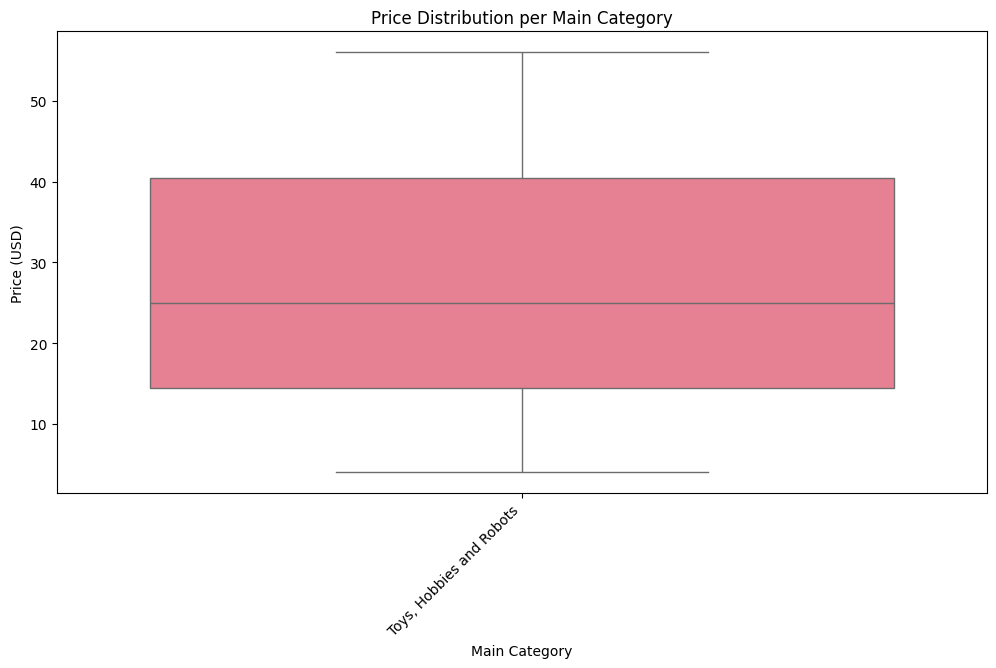

In [ ]:
df_clean = df   # rename if needed

plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean, x="main_category", y="price_clean")
plt.xticks(rotation=45, ha="right")
plt.title("Price Distribution per Main Category")
plt.ylabel("Price (USD)")
plt.xlabel("Main Category")
plt.show()


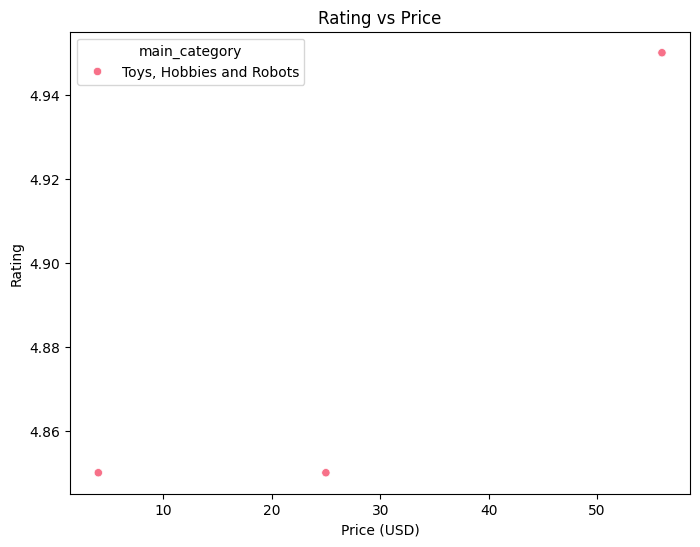

Correlation between Price & Rating: 0.915964221467641


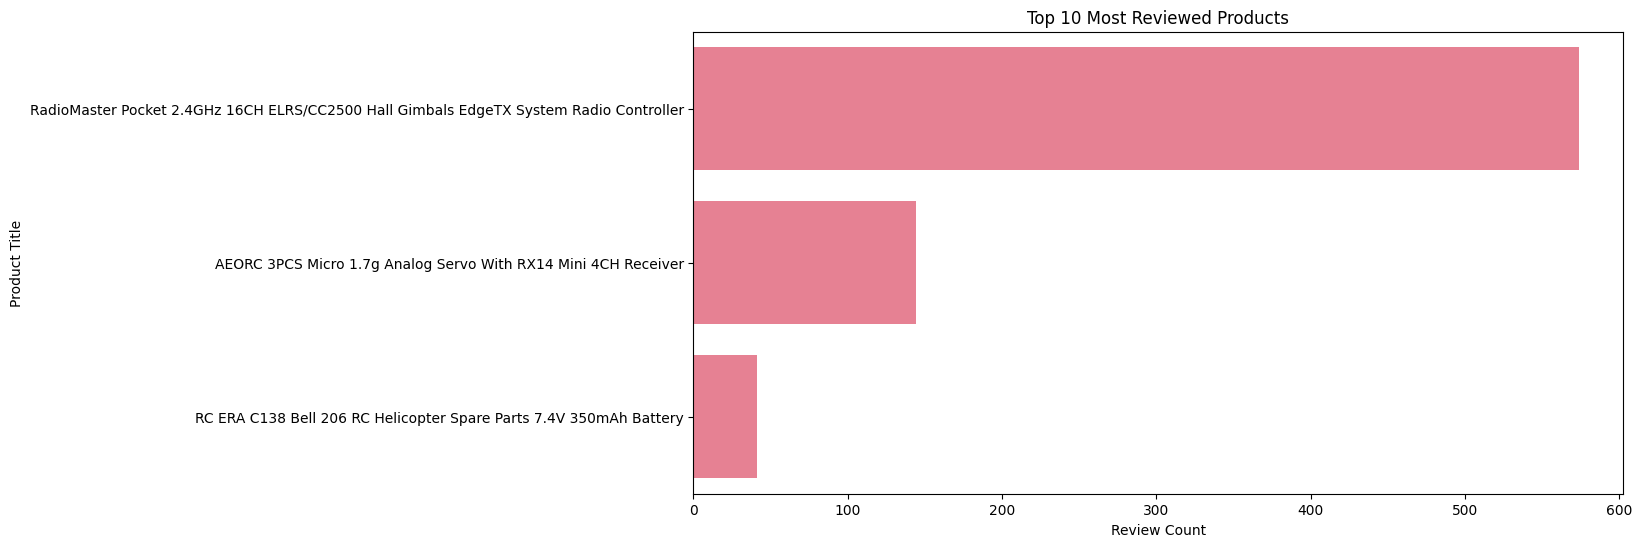

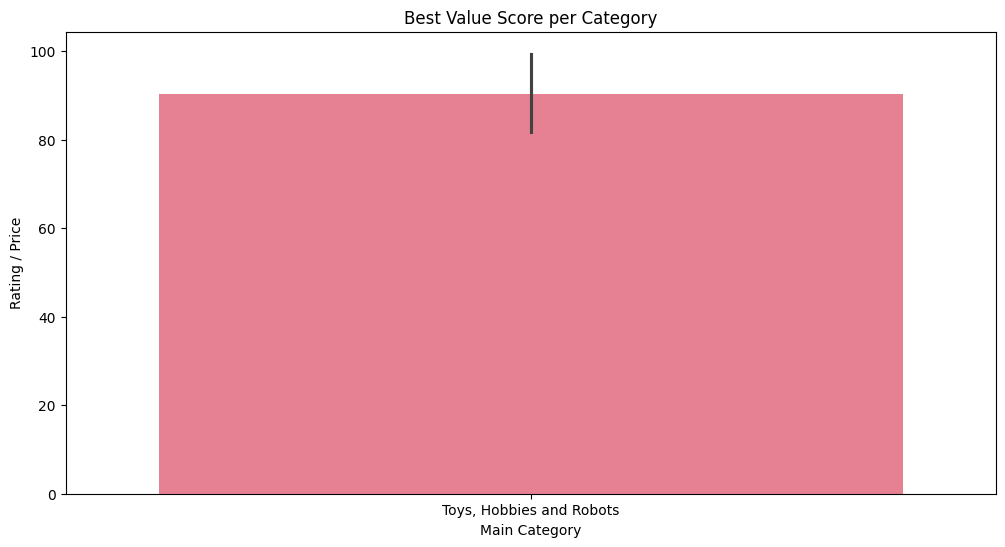

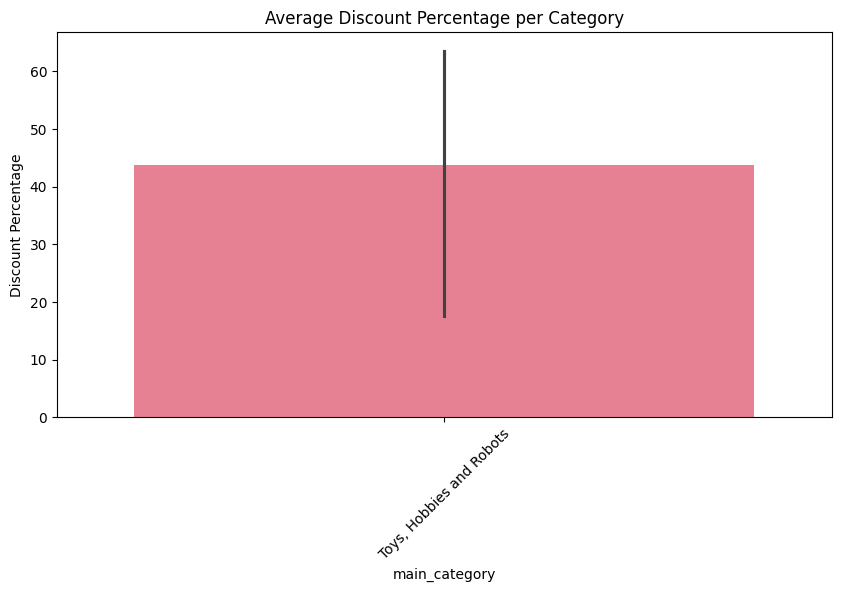

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="price_clean", y="rating_clean", hue="main_category")
plt.title("Rating vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("Rating")
plt.show()

corr = df_clean["price_clean"].corr(df_clean["rating_clean"])
print("Correlation between Price & Rating:", corr)


top_reviewed = df_clean.sort_values("reviews_clean", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_reviewed, y="title", x="reviews_clean")
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Review Count")
plt.ylabel("Product Title")
plt.show()


best_value = df_clean.sort_values("value_score", ascending=False).groupby("main_category").head(5)

plt.figure(figsize=(12,6))
sns.barplot(data=best_value, x="main_category", y="value_score")
plt.title("Best Value Score per Category")
plt.ylabel("Rating / Price")
plt.xlabel("Main Category")
plt.show()


plt.figure(figsize=(10,5))
sns.barplot(data=df_clean, x="main_category", y="discount_percentage")
plt.xticks(rotation=45)
plt.title("Average Discount Percentage per Category")
plt.ylabel("Discount Percentage")
plt.show()


In [ ]:
df.head()

,main_category,subcategory,product_id,title,price_clean,old_price_clean,rating_clean,reviews_clean,price_category,has_discount,discount_percentage,discount_category,rating_per_dollar,reviews_per_dollar,value_score
0,"Toys, Hobbies and Robots",DIY RC Parts,1994795,RadioMaster Pocket 2.4GHz 16CH ELRS/CC2500 Hal...,55.99,67.99,4.95,574,Premium ($50-100),True,17.65,Small Discount (1-20%),0.088409,10.251831,99.400000
1,"Toys, Hobbies and Robots",DIY RC Parts,1995806,AEORC 3PCS Micro 1.7g Analog Servo With RX14 M...,24.99,49.99,4.85,144,Economy ($10-25),True,50.01,Large Discount (41-60%),0.194078,5.762305,89.527944
2,"Toys, Hobbies and Robots",DIY RC Parts,2020606,RC ERA C138 Bell 206 RC Helicopter Spare Parts...,4.00,10.99,4.85,41,Budget (<$10),True,63.60,Huge Discount (61%+),1.212500,10.250000,81.728184


In [ ]:
df.head()

,main_category,subcategory,product_id,title,product_url,price,old_price,reviews_count,rating,image_url,price_clean,old_price_clean,rating_clean,reviews_clean,price_category,has_discount,discount_percentage,discount_category
0,"Toys, Hobbies and Robots",DIY RC Parts,1994795.0,RadioMaster Pocket 2.4GHz 16CH ELRS/CC2500 Hal...,https://www.banggood.com/RadioMaster-Pocket-2_...,US$55.99,US$67.99,574,4.95,https://imgaz3.staticbg.com/thumb/gallery/oaup...,55.99,67.99,4.95,574,Premium ($50-100),True,17.65,Small Discount (1-20%)
1,"Toys, Hobbies and Robots",DIY RC Parts,1995806.0,AEORC 3PCS Micro 1.7g Analog Servo With RX14 M...,https://www.banggood.com/AEORC-3PCS-Micro-1_7g...,US$24.99,US$49.99,144,4.85,https://imgaz.staticbg.com/thumb/gallery/oaupl...,24.99,49.99,4.85,144,Economy ($10-25),True,50.01,Large Discount (41-60%)
2,"Toys, Hobbies and Robots",DIY RC Parts,2020606.0,RC ERA C138 Bell 206 RC Helicopter Spare Parts...,https://www.banggood.com/RC-ERA-C138-Bell-206-...,US$4.00,US$10.99,41,4.85,https://imgaz.staticbg.com/thumb/gallery/oaupl...,4.00,10.99,4.85,41,Budget (<$10),True,63.60,Huge Discount (61%+)
3,"Toys, Hobbies and Robots",DIY RC Parts,2007095.0,YIPINSERVO G25 25kg 7.4V High Speed Voltage St...,https://www.banggood.com/YIPINSERVO-G25-25kg-7...,US$18.39,US$27.99,64,4.83,https://imgaz2.staticbg.com/thumb/gallery/oaup...,18.39,27.99,4.83,64,Economy ($10-25),True,34.30,Medium Discount (21-40%)
4,"Toys, Hobbies and Robots",DIY RC Parts,2014909.0,11.1V 3S1P 3200MAH 25C T Plug Lipo Battery For...,https://www.banggood.com/11_1V-3S1P-3200MAH-25...,US$18.94,US$26.99,44,4.82,https://imgaz2.staticbg.com/thumb/gallery/oaup...,18.94,26.99,4.82,44,Economy ($10-25),True,29.83,Medium Discount (21-40%)


In [16]:
!pip install pyodbc


In [1]:
# import pandas as pd
# import pyodbc
# from sqlalchemy import create_engine

# # 1. Set up the SQL Server connection using pyodbc
# server = 'localhost'  # e.g. 'localhost' or IP
# database = 'banggood_analysis'
# username = 'DESKTOP-HV9GJ62/hp'
# password = '1998'

# # Create connection using pyodbc (You may need to install ODBC driver for SQL Server)
# conn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')
# cursor = conn.cursor()

# # 2. Create SQL table if it doesn't exist (optional)
# # You can skip this step if the table already exists

# # Dynamically create table if it doesn't exist (example uses VARCHAR for simplicity)
# table_name = "your_table_name"
# column_defs = ', '.join([f"{col} VARCHAR(255)" for col in df.columns])

# create_table_query = f"""
# IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table_name}' AND xtype='U')
# BEGIN
#     CREATE TABLE {table_name} (
#         {column_defs}
#     )
# END
# """

# cursor.execute(create_table_query)
# conn.commit()

# # 3. Insert DataFrame into SQL Server
# # Using pyodbc for inserting data
# for row in df.itertuples(index=False, name=None):
#     cursor.execute(f"""
#     INSERT INTO {table_name} ({', '.join(df.columns)})
#     VALUES ({', '.join(['?' for _ in df.columns])})
#     """, row)
    
# conn.commit()

# # Alternatively, using SQLAlchemy (to_sql method)
# # Creating SQLAlchemy engine
# engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=SQL+Server')

# # Insert data using pandas to_sql method
# df.to_sql(table_name, con=engine, if_exists='replace', index=False)

# # Close the connection
# cursor.close()
# conn.close()
